# Conceitos de underfitting, overfitting e regularização

Esse tutorial visa explicar os conceitos de *underfitting*, *overfitting* e regularização através de um exemplo de ajuste de curva usando o Pytorch.

*Underfitting* ocorre quando o modelo não é capaz de representar a natureza dos dados. Normalmente resolve-se o *underfitting* aumentando a complexidade do modelo de ajuste; em redes neurais, isso é equivalente a aumentar o número de camadas e o número de neurônios por camada.

*Overfitting* ocorre quando o modelo se adequa excessivamente aos dados de treinamento, de forma que ele se torna específico demais para os dados de treinamento e torna-se incapaz de generalizar para novos dados.

Regularização é uma técnica para evitar o *overfitting*.

O tutorial é uma adaptação do exemplo apresentado no capítulo 1 do livro:
"Christopher M. Bishop. 2006. Pattern Recognition and Machine Learning (Information Science and Statistics). Springer-Verlag New York, Inc., Secaucus, NJ, USA."



In [4]:
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console contrib dejavu events execute kernel kernelspec
lab labextension labhub migrate nbconvert nbextensions_configurator notebook
run server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


## Importação das bibliotecas - NumPy, matplotlib e ipywidgets

In [5]:
# http://pytorch.org/
from os.path import exists
import torch

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as widgets

import time
import copy
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

## Gerando dados sintéticos com ruído


In [7]:
def generate_dataset(n_points=15, noise_stdev=0.3, rnd_seed=20):
    torch.manual_seed(rnd_seed)

    train_size = n_points
    test_size = n_points

    # Ruido gaussiano
    noise_mean = torch.zeros(train_size)
    noise_std = noise_stdev

    x_true = torch.linspace(0.0, 1.0, 100)
    y_true = torch.sin(2.0 * np.pi * x_true)

    x_samples = torch.linspace(0.0, 1.0, 2 * n_points + 20)
    idx = torch.randperm(2 * n_points + 20)
    tra_idx = idx[:train_size]
    tst_idx = idx[-test_size:]

    # Conjunto de validação
    x_test = x_samples[tst_idx].view(-1, 1)
    y_test = torch.sin(2.0 * np.pi * x_test[:, 0]) + torch.normal(noise_mean, noise_std)

    # Conjunto de treino
    x_train = x_samples[tra_idx].view(-1, 1)
    y_train = torch.sin(2.0 * np.pi * x_train[:, 0]) + torch.normal(noise_mean, noise_std)

    #input and target shapes do not match: input [15 x 1], target [15] at /pytorch/aten/src/THNN/generic/MSECriterion.c:12


    y_train = y_train.reshape(15, 1)
    y_test = y_test.reshape(15, 1)

    return x_true, y_true, x_train, y_train, x_test, y_test


## Rede neural e procedimento de treino

In [8]:
class Net(nn.Module):
    def __init__(self, n_hidden_neurons):
        super(Net, self).__init__()
        self.n_hidden = n_hidden_neurons
        if n_hidden_neurons == 0:
            self.linear01 = nn.Linear(in_features=1, out_features=1)
        else:
            self.linear01 = nn.Linear(in_features=1, out_features=n_hidden_neurons)
            self.linear02 = nn.Linear(in_features=n_hidden_neurons, out_features=1)

    def forward(self, x):
        if self.n_hidden == 0:
            x = self.linear01(x)
        else:
            x = self.linear01(x)
            x = F.sigmoid(x)
            x = self.linear02(x)
        return x


def train_model(model, x_train, y_train, x_test, y_test, lr=0.1, reg_factor=0.0, n_epochs=100, use_gpu=False):
    criterion = torch.nn.MSELoss()

    optimizer = torch.optim.Adam(params=model.parameters(),
                                 lr=lr, weight_decay=reg_factor)
    if use_gpu:
        model = model.cuda()
        x_train, y_train = Variable(x_train.cuda()), Variable(y_train.cuda())
        x_test, y_test = Variable(x_test.cuda()), Variable(y_test.cuda())
    else:
        x_train, y_train = Variable(x_train), Variable(y_train)
        x_test, y_test = Variable(x_test), Variable(y_test)

    train_losses = []
    test_losses = []
    train_preds = []
    test_preds = []
    for i in range(n_epochs):
        try:
            model.train(True)
            optimizer.zero_grad()
            train_pred = model(x_train)
            train_loss = criterion(train_pred, y_train)
            train_loss.backward()
            optimizer.step()

            model.train(False)
            test_pred = model(x_test)
            test_loss = criterion(test_pred, y_test)

            train_losses.append(train_loss.data)
            test_losses.append(test_loss.data)

            train_preds.append(train_pred.data)
            test_preds.append(test_pred.data)

        except KeyboardInterrupt:
            print('Training interrupted!')
            break

    return train_losses, test_losses, train_preds, test_preds


## Procedimentos para criação de gráficos interativos

In [9]:
def show_network_plots(n_data=15, noise=0.3, neurons=16, epochs=500, lr=0.1, L2_reg=0.0,
                       t_train=False, t_test=False):
    global model

    model = Net(neurons)
    x_true, y_true, x_train, y_train, x_test, y_test = generate_dataset(n_points=n_data, noise_stdev=noise)
    tra_loss, tst_loss, tra_preds, tst_preds = train_model(model, x_train, y_train, x_test, y_test,
                                                           lr=lr, reg_factor=L2_reg, n_epochs=epochs)

    fig = plt.figure(figsize=(15,4))

    fig.add_subplot(1, 2, 1)
    plt.plot(tra_loss, color='blue', label='training')
    plt.plot(tst_loss, color='red', label='validation')
    plt.ylim(0, 1.0)
    plt.grid()
    plt.legend()

    print('Losses:  T={:.5f},  V={:.5f}'.format(tra_loss[-1], tst_loss[-1]))

    fig.add_subplot(1, 2, 2)
    plt.plot(x_true.numpy(), y_true.numpy(), color='orange')
    plt.plot(x_train.numpy(), tra_preds[-1].numpy(), 'o', color='blue', label='training')
    plt.plot(x_test.numpy(), tst_preds[-1].numpy(), 'o', color='red', label='validation')
    if t_train:
        plt.plot(x_train.numpy(), y_train.numpy(), 'x', color='blue')
    if t_test:
        plt.plot(x_test.numpy(), y_test.numpy(), 'x', color='red')
    plt.ylim(-1.6, 1.6)
    plt.grid()
    plt.legend()


def showIt(n_data=15, noise=0.3, neurons=16, epochs=400, lr=0.1, L2_reg=0.0, t_train=False, t_test=False):
    s_ndata = widgets.IntSlider(min=10, max=20, step=1, value=n_data, continuous_update=False)
    s_epochs = widgets.IntSlider(min=10, max=800, step=10, value=epochs, continuous_update=False)
    s_neurons = widgets.IntSlider(min=0, max=32, step=1, value=neurons, continuous_update=False)

    s_noise = widgets.FloatSlider(min=0.1, max=0.5, step=0.1, value=noise, readout_format='.1f',
                                  continuous_update=False)
    s_lr = widgets.FloatSlider(min=0.01, max=0.1, step=0.01, value=lr, readout_format='.3f',
                               continuous_update=False)
    s_L2_reg = widgets.FloatSlider(min=0.0, max=0.005, step=0.0001, value=L2_reg, readout_format='.4f',
                                   continuous_update=False)

    widgets.interact(show_network_plots, epochs=s_epochs, noise=s_noise,
                     neurons=s_neurons, lr=s_lr, L2_reg=s_L2_reg);

# Experimentos

## Underfitting

interactive(children=(IntSlider(value=15, description='n_data', max=45, min=-15), FloatSlider(value=0.3, conti…

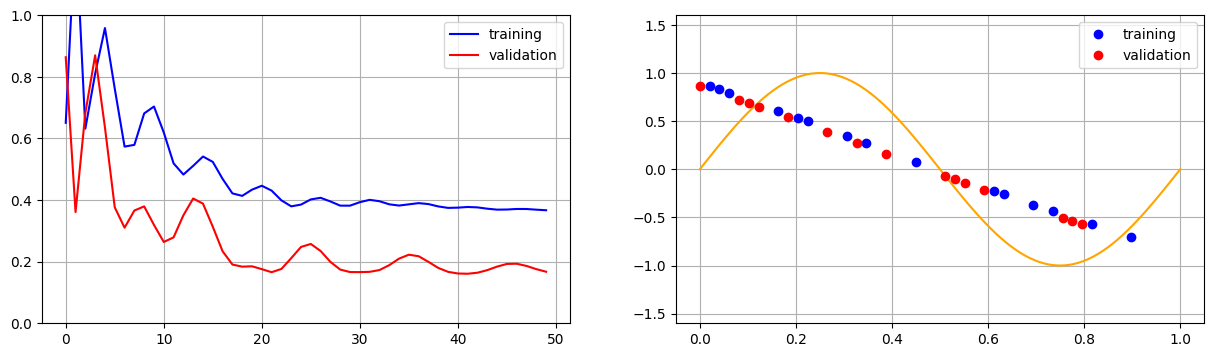

In [15]:
showIt(epochs=50)

## Overfitting

interactive(children=(IntSlider(value=15, description='n_data', max=45, min=-15), FloatSlider(value=0.3, conti…

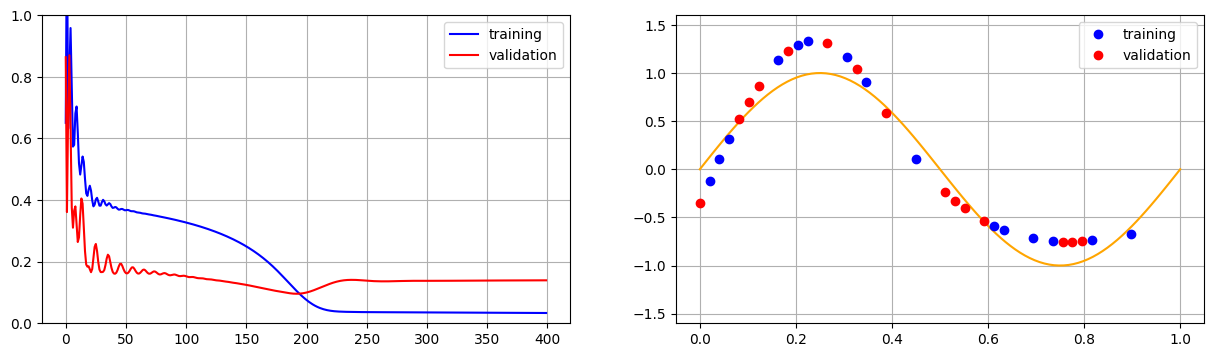

In [11]:
showIt()

## Early Stopping

interactive(children=(IntSlider(value=15, description='n_data', max=45, min=-15), FloatSlider(value=0.3, conti…

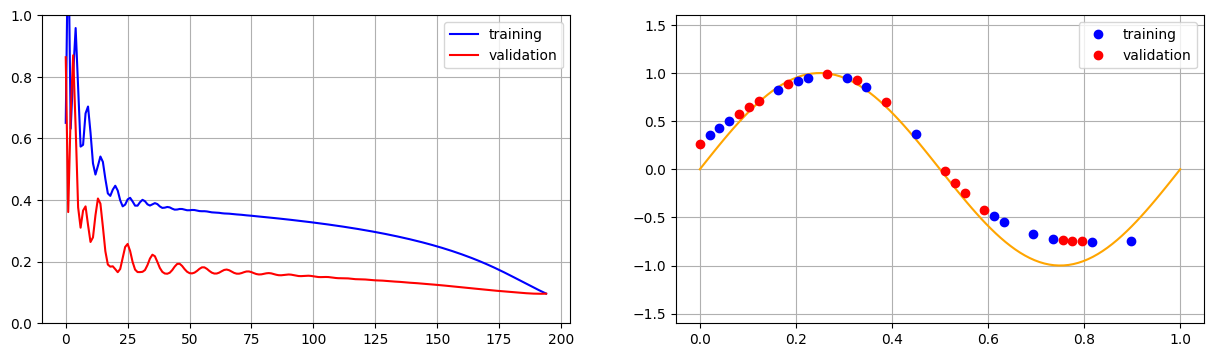

In [12]:
showIt(epochs=195)

## Regularização L2

$$\Large E(\boldsymbol{w})=\frac{1}{2}\sum_{n=1}^N\{\hat{y}(x_n,\boldsymbol{w})-y_n\}^2 +\frac{\lambda}{2}||\boldsymbol{W}||^2$$

interactive(children=(IntSlider(value=15, description='n_data', max=45, min=-15), FloatSlider(value=0.3, conti…

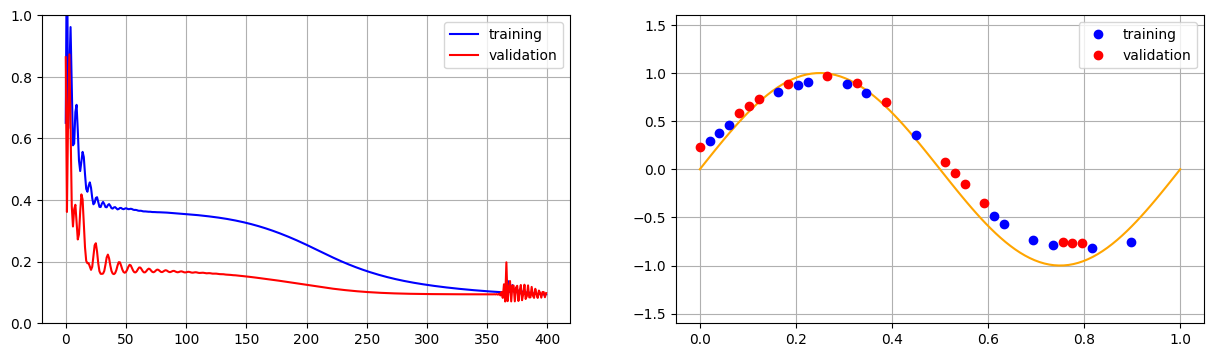

In [13]:
showIt(L2_reg=0.002)

## Histograma dos pesos

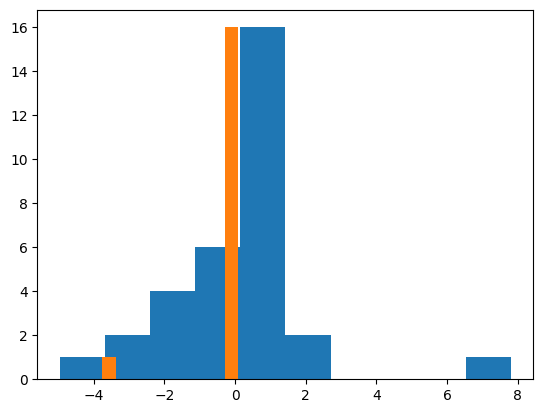

In [14]:
ww = torch.cat([p[1].view(-1) for p in model.named_parameters() if p[0].endswith('weight')])
bb = torch.cat([p[1].view(-1) for p in model.named_parameters() if p[0].endswith('bias')])
plt.hist(ww.data.numpy())
plt.hist(bb.data.numpy());

# Exercícios

1. Acesse a página http://playground.tensorflow.org e utilizando apenas 2 entradas (x1 e x2), procure variar os
diversos parâmetros:
    - número de camadas
    - número de neurônios em cada camada
    - tipo de ativação
    - learning rate
    - fator de regularização
    
Resolva para o dataset "Spiral".

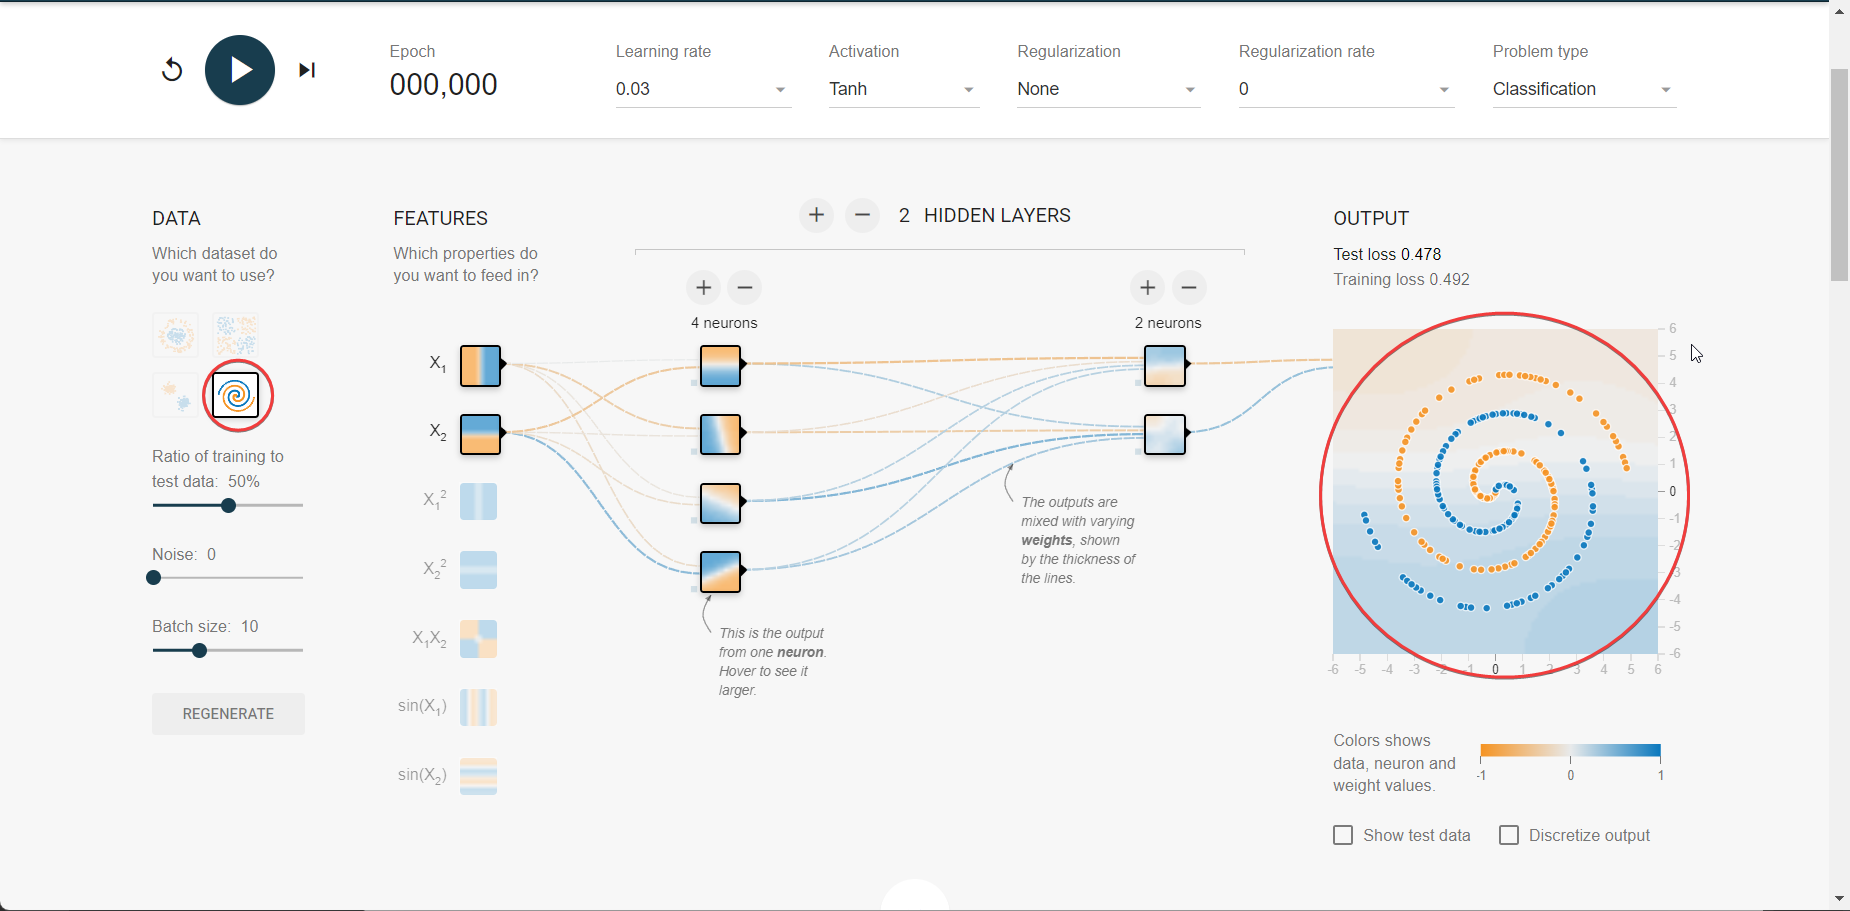

Coloque abaixo uma screenshot da tela com sua solução e comente sobre o que aprendeu nesse exercício (qual o impacto do número de camadas, neurônios em cada camada, ativação, learning rate e regularização).

    

### Tentaiva 1
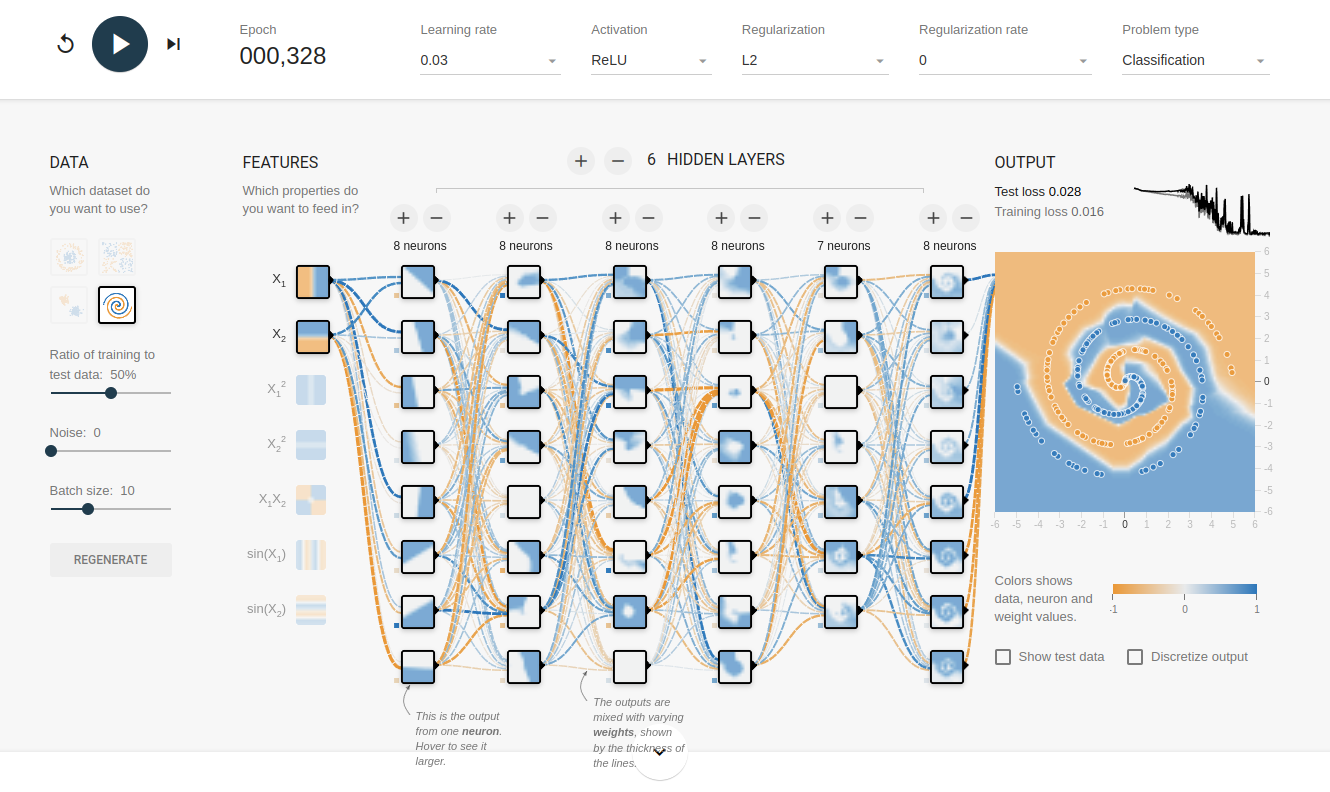


### Tentativa 2
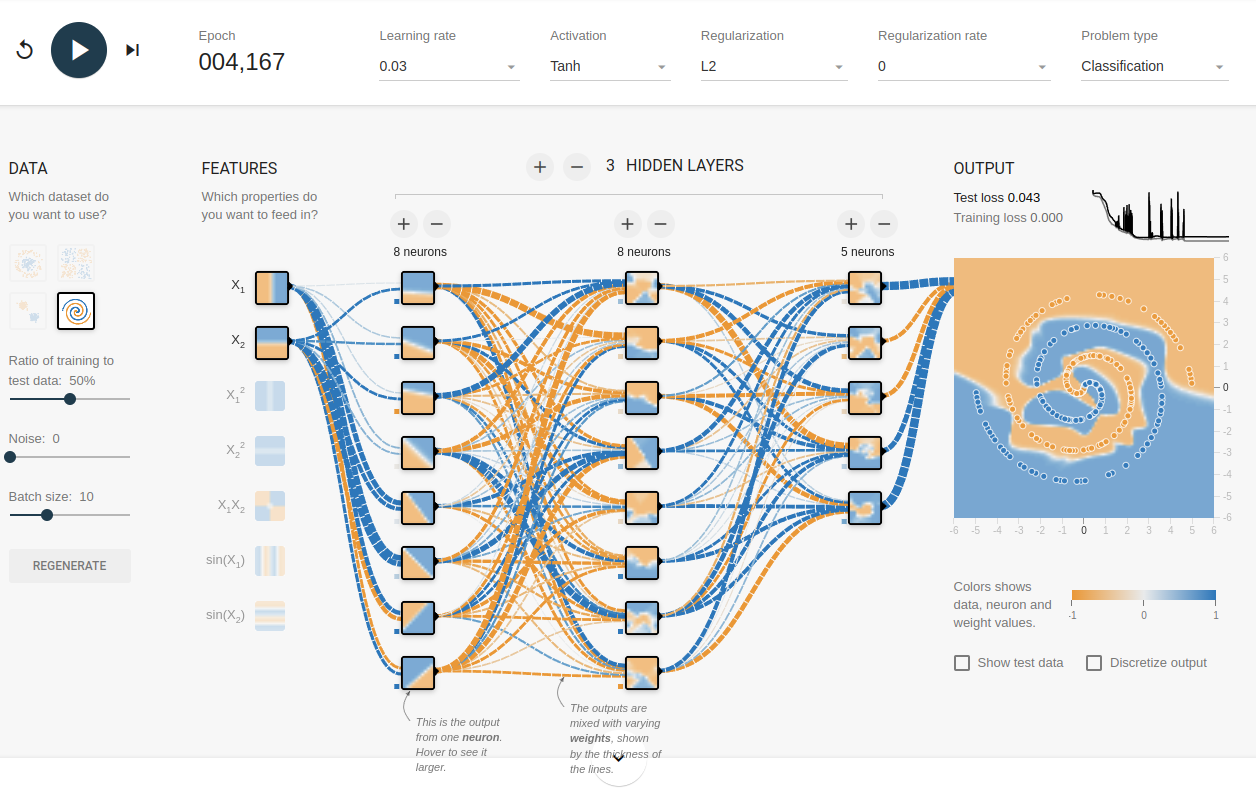

### Tentativa 3
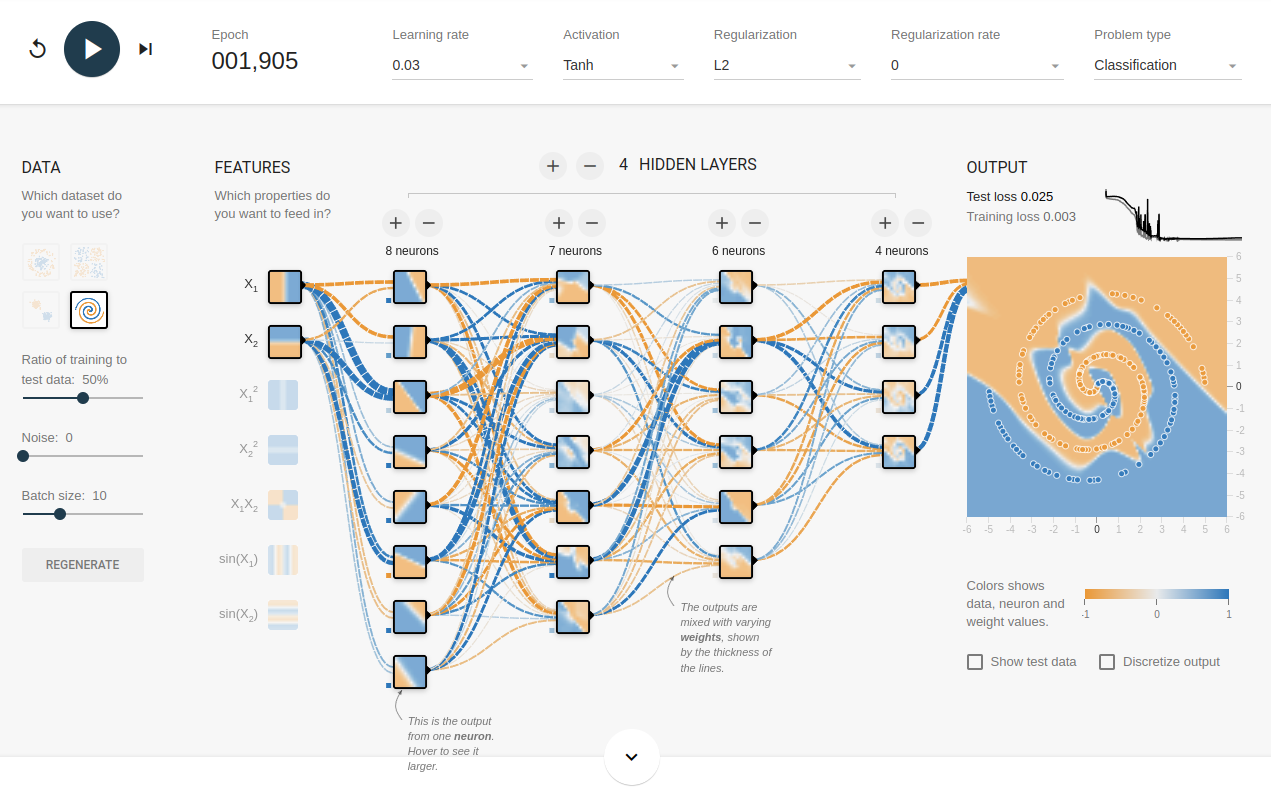